In [ ]:
# Install necessary packages
install.packages(c("sparklyr", "dplyr", "ggplot2", "lubridate",
                   "wordcloud", "tidytext", "tidyr", "RColorBrewer",
                   "tm", "reshape2"), repos='http://cran.us.r-project.org')


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Load the required libraries
library(sparklyr)
library(dplyr)
library(ggplot2)
library(lubridate)
library(wordcloud)
library(tidytext)
library(tidyr)
library(RColorBrewer)
library(tm)
library(reshape2)



Attaching package: ‘sparklyr’


The following object is masked from ‘package:stats’:

    filter



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: RColorBrewer

Loading required package: NLP


Attaching package: ‘NLP’


The following object is masked from ‘package:ggplot2’:

    annotate



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [ ]:
# Install Spark using sparklyr
spark_install(version = "3.4.0")

# Initialize Spark connection
sc <- spark_connect(master = "local")

In [ ]:
# Paths to the data files
diagnoses_icd_path <- '/content/diagnosis_icd_reduced.csv'
noteevents_path <- '/content/note_events_reduced.csv'
procedures_icd_path <- '/content/procedures_icd_reduced.csv'

# Read CSV files into data frames
diagnoses_df <- read.csv(diagnoses_icd_path, stringsAsFactors = FALSE)
noteevents_df <- read.csv(noteevents_path, stringsAsFactors = FALSE)
procedures_df <- read.csv(procedures_icd_path, stringsAsFactors = FALSE)


In [ ]:
# Clean the datasets by removing missing values and duplicates
diagnoses_df_clean <- diagnoses_df %>%
  filter(!is.na(SUBJECT_ID) & !is.na(ICD9_CODE)) %>%
  distinct(SUBJECT_ID, ICD9_CODE, .keep_all = TRUE)

noteevents_df_clean <- noteevents_df %>%
  filter(!is.na(SUBJECT_ID) & TEXT != "") %>%
  distinct(SUBJECT_ID, TEXT, .keep_all = TRUE)

procedures_df_clean <- procedures_df %>%
  filter(!is.na(SUBJECT_ID) & !is.na(ICD9_CODE)) %>%
  distinct(SUBJECT_ID, ICD9_CODE, .keep_all = TRUE)

# Rename columns to avoid ambiguity
colnames(diagnoses_df_clean)[colnames(diagnoses_df_clean) == "ICD9_CODE"] <- "DIAGNOSIS_CODE"
colnames(procedures_df_clean)[colnames(procedures_df_clean) == "ICD9_CODE"] <- "PROCEDURE_CODE"

# Join diagnoses and procedures on SUBJECT_ID
diagnoses_procedures_df <- merge(diagnoses_df_clean, procedures_df_clean, by = "SUBJECT_ID")


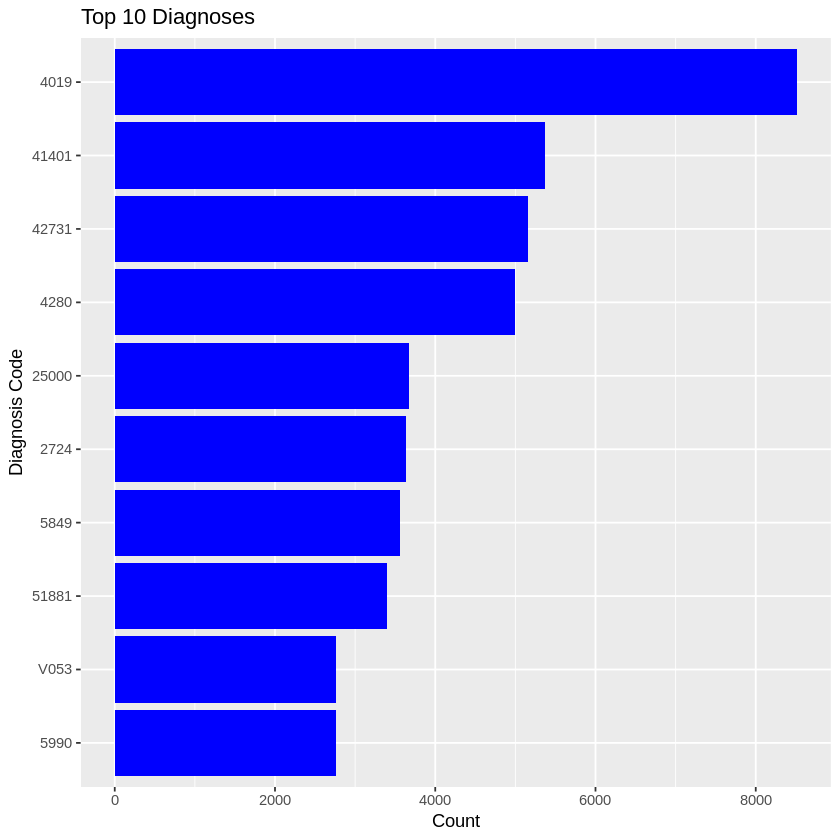

In [ ]:
# Top 10 diagnoses
top_diagnoses_df <- diagnoses_df_clean %>%
  group_by(DIAGNOSIS_CODE) %>%
  summarise(count = n()) %>%
  arrange(desc(count)) %>%
  head(10)

# Bar plot for top diagnoses
ggplot(top_diagnoses_df, aes(x = reorder(DIAGNOSIS_CODE, count), y = count)) +
  geom_bar(stat = "identity", fill = "blue") +
  coord_flip() +
  labs(title = "Top 10 Diagnoses", x = "Diagnosis Code", y = "Count")


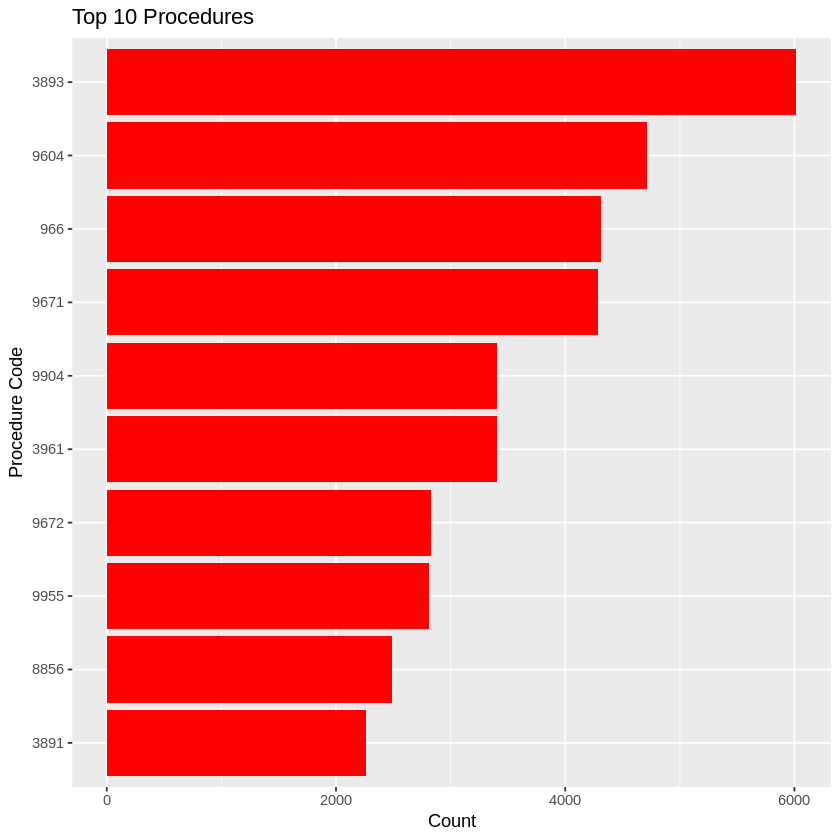

In [ ]:
# Top 10 procedures
top_procedures_df <- procedures_df_clean %>%
  group_by(PROCEDURE_CODE) %>%
  summarise(count = n()) %>%
  arrange(desc(count)) %>%
  head(10)

# Bar plot for top procedures
ggplot(top_procedures_df, aes(x = reorder(PROCEDURE_CODE, count), y = count)) +
  geom_bar(stat = "identity", fill = "red") +
  coord_flip() +
  labs(title = "Top 10 Procedures", x = "Procedure Code", y = "Count")


In [ ]:
# Generate word cloud
library(tm)
library(wordcloud)

# Create corpus and preprocess text
corpus <- Corpus(VectorSource(noteevents_df_clean$TEXT))
corpus <- tm_map(corpus, content_transformer(tolower))
corpus <- tm_map(corpus, removePunctuation)
corpus <- tm_map(corpus, removeNumbers)
corpus <- tm_map(corpus, removeWords, stopwords("en"))

# Create word cloud
wordcloud(corpus, max.words = 100, random.order = FALSE, colors = brewer.pal(8, "Dark2"))


Warning message in tm_map.SimpleCorpus(corpus, content_transformer(tolower)):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removePunctuation):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removeNumbers):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removeWords, stopwords("en")):
“transformation drops documents”


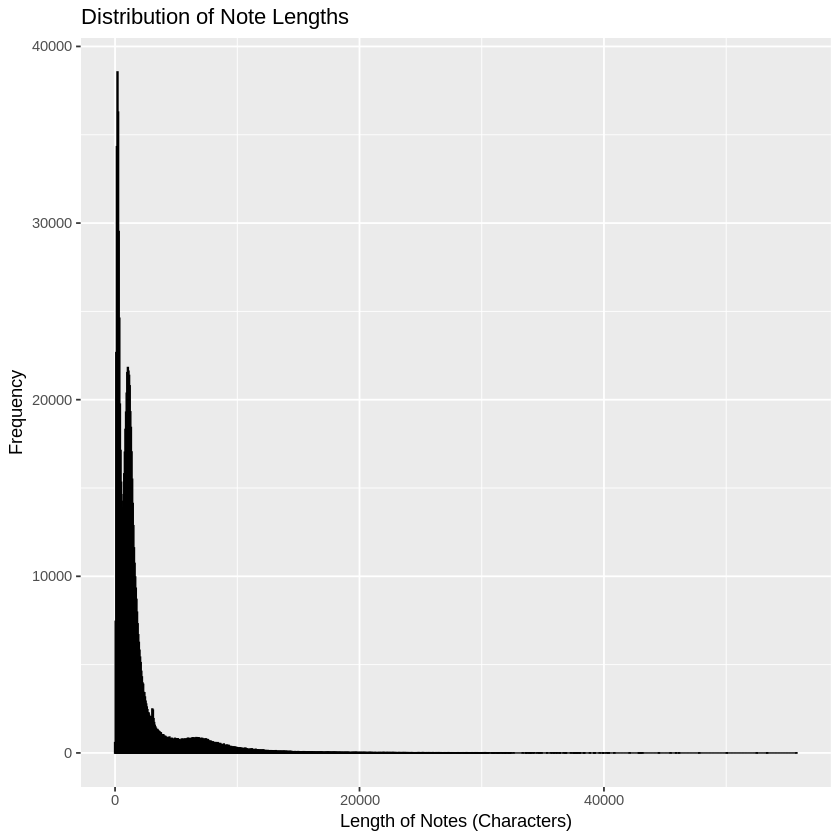

In [ ]:
# Analyze note lengths
note_lengths_df <- noteevents_df_clean %>%
  mutate(note_length = nchar(TEXT))

# Plot histogram
ggplot(note_lengths_df, aes(x = note_length)) +
  geom_histogram(binwidth = 50, fill = "green", color = "black") +
  labs(title = "Distribution of Note Lengths", x = "Length of Notes (Characters)", y = "Frequency")


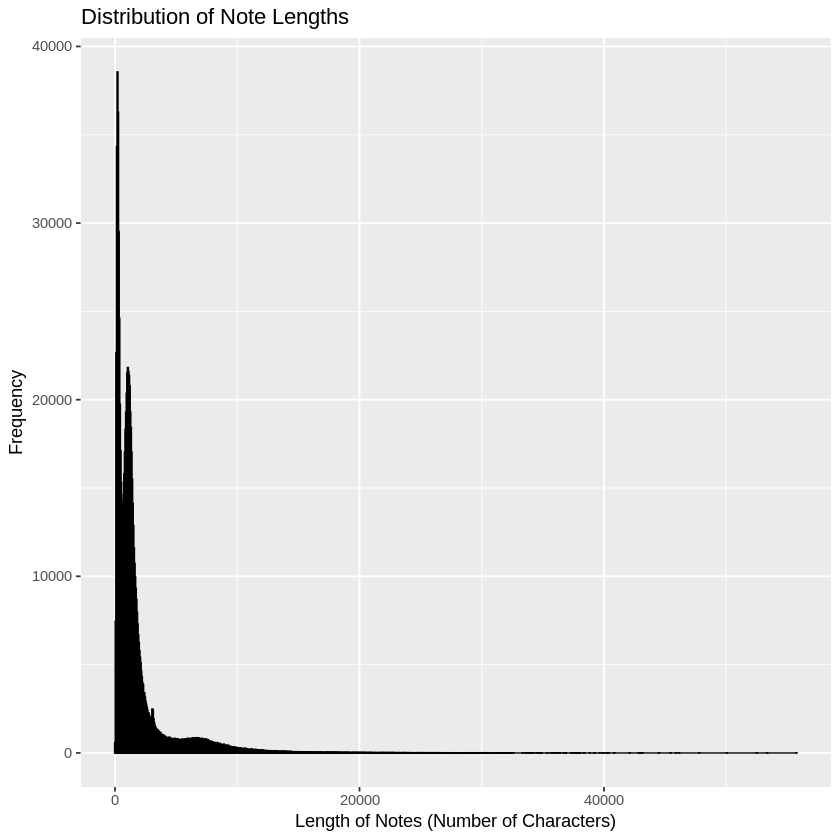

In [ ]:
# Calculate note lengths
note_lengths_df <- noteevents_df_clean %>%
  mutate(note_length = nchar(TEXT))

# Plot histogram
ggplot(note_lengths_df, aes(x = note_length)) +
  geom_histogram(binwidth = 50, fill = "green", color = "black", alpha = 0.7) +
  labs(title = 'Distribution of Note Lengths',
       x = 'Length of Notes (Number of Characters)',
       y = 'Frequency')


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


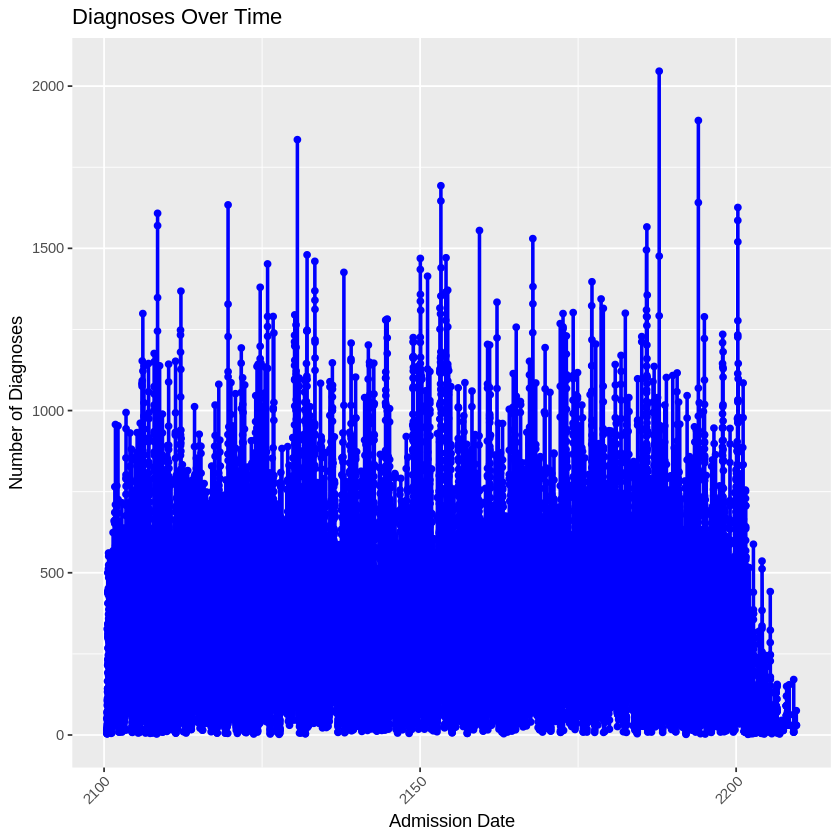

In [ ]:
# Convert CHARTDATE to Date type
noteevents_df_clean$CHARTDATE <- as.Date(noteevents_df_clean$CHARTDATE, format="%Y-%m-%d")

# Join diagnoses and note events to analyze over time
diagnoses_over_time <- merge(diagnoses_df_clean, noteevents_df_clean, by = c("SUBJECT_ID", "HADM_ID")) %>%
  group_by(CHARTDATE) %>%
  summarise(count = n())

# Line plot
ggplot(diagnoses_over_time, aes(x = CHARTDATE, y = count)) +
  geom_line(color = 'blue', size = 1) +
  geom_point(color = 'blue') +
  labs(title = 'Diagnoses Over Time',
       x = 'Admission Date',
       y = 'Number of Diagnoses') +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


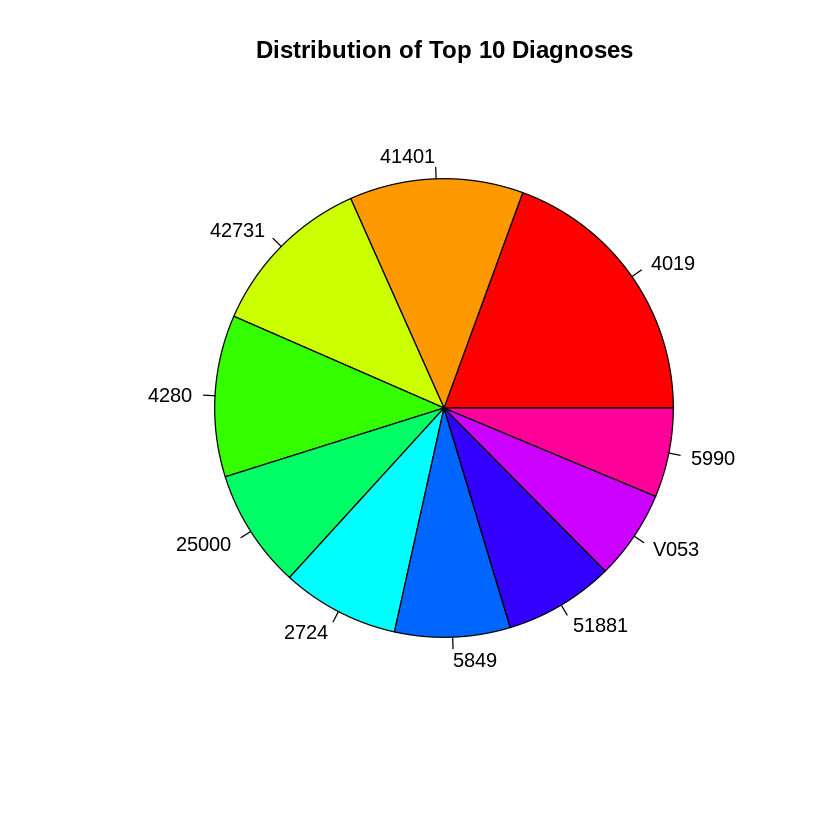

In [ ]:
# Top 10 diagnoses
top_diagnoses <- diagnoses_df_clean %>%
  group_by(DIAGNOSIS_CODE) %>%
  summarise(count = n()) %>%
  arrange(desc(count)) %>%
  head(10)

# Pie chart
pie(top_diagnoses$count, labels = top_diagnoses$DIAGNOSIS_CODE, col = rainbow(10), main = "Distribution of Top 10 Diagnoses")


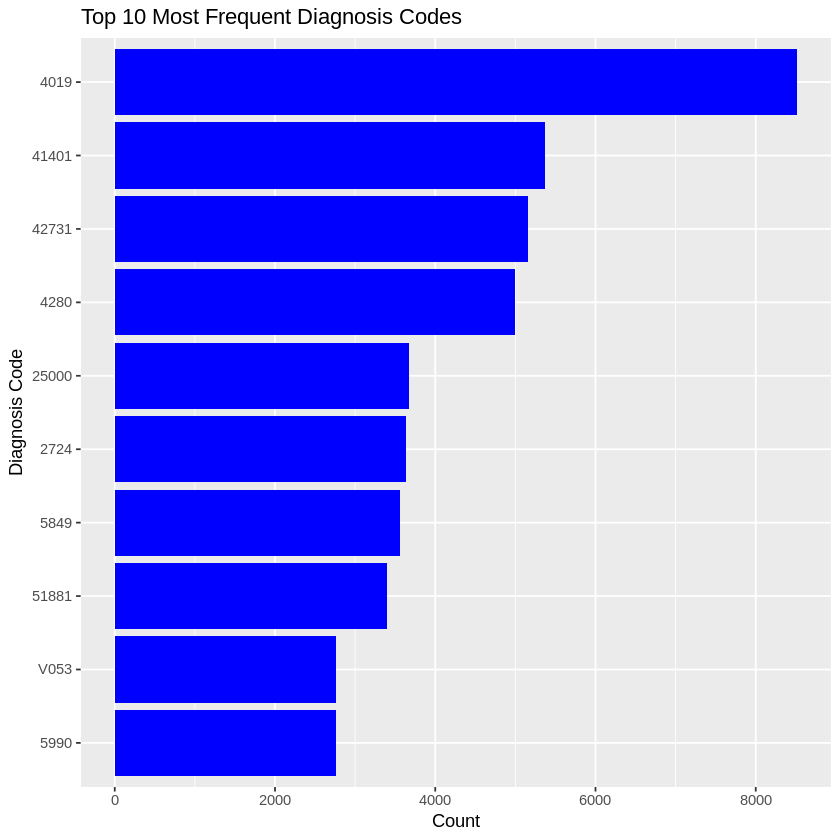

In [ ]:
# Bar plot of top 10 diagnosis codes
ggplot(top_diagnoses, aes(x = reorder(DIAGNOSIS_CODE, count), y = count)) +
  geom_bar(stat = "identity", fill = "blue") +
  coord_flip() +
  labs(title = 'Top 10 Most Frequent Diagnosis Codes',
       x = 'Diagnosis Code',
       y = 'Count')


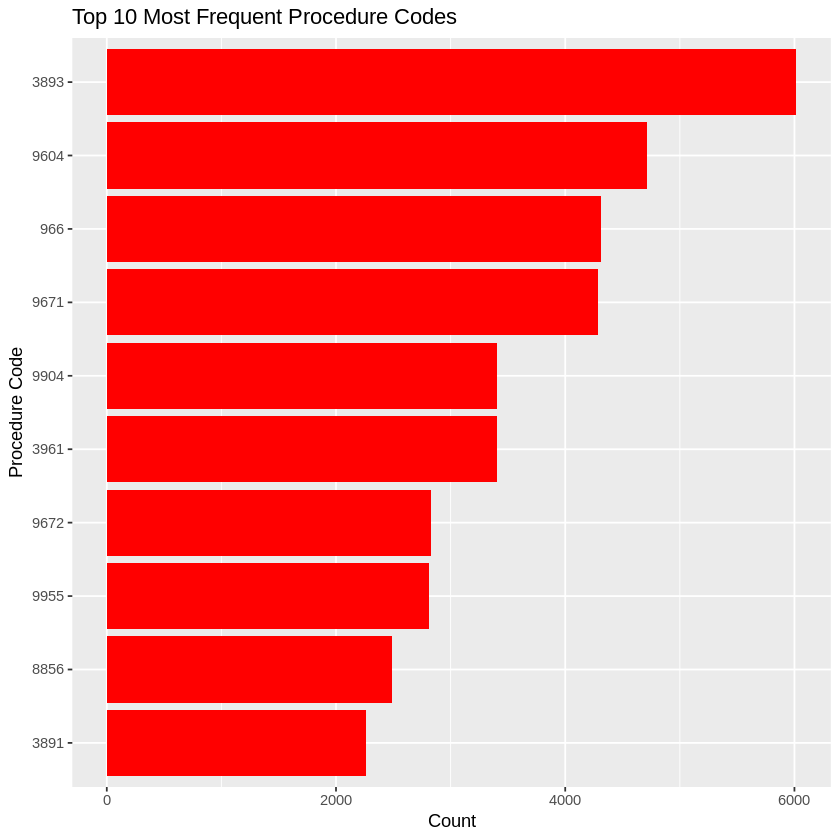

In [ ]:
# Calculate top 10 procedure codes
top_procedures <- procedures_df_clean %>%
  group_by(PROCEDURE_CODE) %>%
  summarise(count = n()) %>%
  arrange(desc(count)) %>%
  head(10)

# Bar plot for top procedures
ggplot(top_procedures, aes(x = reorder(PROCEDURE_CODE, count), y = count)) +
  geom_bar(stat = "identity", fill = "red") +
  coord_flip() +
  labs(title = 'Top 10 Most Frequent Procedure Codes',
       x = 'Procedure Code',
       y = 'Count')


In [ ]:
# Convert the column names by replacing single quotes and spaces with an empty string
colnames(diagnoses_df_clean) <- gsub("'", "", colnames(diagnoses_df_clean))

# Extract year and month from the diagnosis date for trend analysis
# Here, we assume that 'DIAGNOSIS_CODE' is your diagnosis column and 'HADM_ID' might be used to link with dates (if applicable)
# Since there is no date column, please adjust as needed or provide the correct date field if available.

# Check if CHARTDATE (or its equivalent) exists in the data frame
# If not, you will need to include the correct date column as per your dataset structure.
if ("CHARTDATE" %in% colnames(diagnoses_df_clean)) {
  # Extract year and month from the chart date for trend analysis
  diagnoses_over_time <- diagnoses_df_clean %>%
    mutate(CHARTDATE = as.Date(CHARTDATE, format="%Y-%m-%d")) %>%  # Ensure CHARTDATE is a Date
    mutate(Month = format(CHARTDATE, "%Y-%m")) %>%
    group_by(Month) %>%
    summarise(count = n(), .groups = 'drop')  # Add .groups argument to suppress warning

  # Plot monthly trend
  ggplot(diagnoses_over_time, aes(x = Month, y = count)) +
    geom_line(color = 'purple', size = 1) +
    geom_point(color = 'purple') +
    labs(title = 'Monthly Trend of Diagnoses',
         x = 'Month',
         y = 'Number of Diagnoses') +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

} else {
  # Handle the case when CHARTDATE is not found
  print("CHARTDATE column not found. Please check your dataset for the appropriate date column.")
}


[1] "CHARTDATE column not found. Please check your dataset for the appropriate date column."


Joining with `by = join_by(word)`


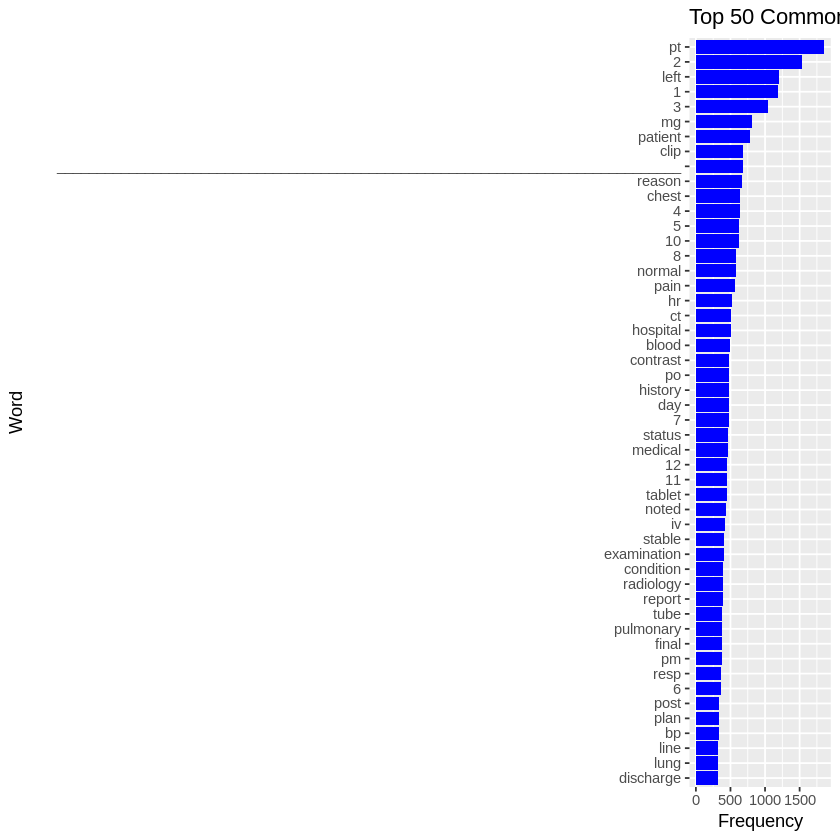

In [ ]:
# Load necessary libraries
library(dplyr)
library(ggplot2)
library(tidytext)

# Create a tidy text data frame
word_df <- noteevents_df_clean %>%
  unnest_tokens(word, TEXT) %>%                # Tokenize the text into words
  anti_join(stop_words) %>%                    # Remove stop words
  count(word, sort = TRUE) %>%                 # Count occurrences of each word
  head(50)                                      # Get the top 20 words

# Plot top 20 words
ggplot(word_df, aes(x = reorder(word, n), y = n)) +
  geom_bar(stat = "identity", fill = "blue") +
  coord_flip() +
  labs(title = 'Top 50 Common Words in Clinical Notes',
       x = 'Word',
       y = 'Frequency')


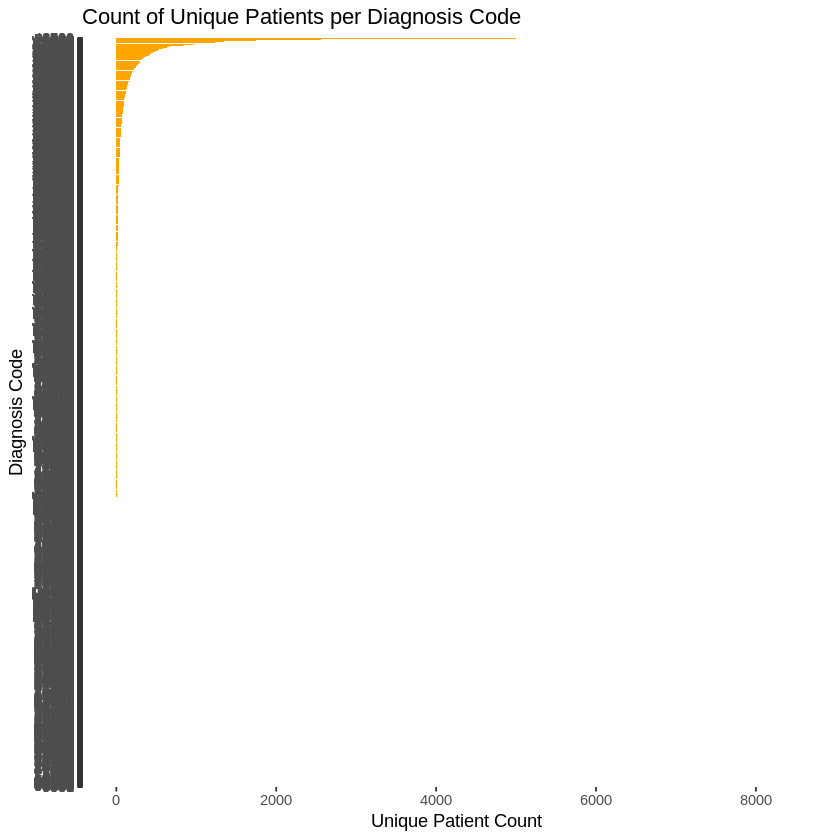

In [ ]:
# Count of unique patients per diagnosis code
unique_patients_per_diagnosis <- diagnoses_df_clean %>%
  group_by(DIAGNOSIS_CODE) %>%
  summarise(unique_patients = n_distinct(SUBJECT_ID))

# Plot
ggplot(unique_patients_per_diagnosis, aes(x = reorder(DIAGNOSIS_CODE, unique_patients), y = unique_patients)) +
  geom_bar(stat = "identity", fill = "orange") +
  coord_flip() +
  labs(title = 'Count of Unique Patients per Diagnosis Code',
       x = 'Diagnosis Code',
       y = 'Unique Patient Count')


In [ ]:
# Basic statistics of note lengths
note_lengths <- nchar(noteevents_df_clean$TEXT)
note_summary <- data.frame(
  Mean_Length = mean(note_lengths, na.rm = TRUE),
  Median_Length = median(note_lengths, na.rm = TRUE),
  Min_Length = min(note_lengths, na.rm = TRUE),
  Max_Length = max(note_lengths, na.rm = TRUE),
  Total_Notes = nrow(noteevents_df_clean)
)

print(note_summary)


  Mean_Length Median_Length Min_Length Max_Length Total_Notes
1    1635.511          1140         18      19383        1000


In [ ]:
# Frequency of each diagnosis code
diagnosis_frequency <- table(diagnoses_df_clean$DIAGNOSIS_CODE)
top_diagnoses <- head(sort(diagnosis_frequency, decreasing = TRUE), 10)

# Create a data frame for easier interpretation
top_diagnoses_df <- data.frame(Diagnosis_Code = names(top_diagnoses), Frequency = as.vector(top_diagnoses))
print(top_diagnoses_df)


   Diagnosis_Code Frequency
1            4019        29
2           41401        28
3            4280        22
4            2720        19
5           42731        18
6            V290        16
7           25000        12
8            V053        12
9            5849        11
10            496        10


In [ ]:
# Frequency of each procedure code
procedure_frequency <- table(procedures_df$ICD9_CODE)
top_procedures <- head(sort(procedure_frequency, decreasing = TRUE), 10)

# Create a data frame for easier interpretation
top_procedures_df <- data.frame(Procedure_Code = names(top_procedures), Frequency = as.vector(top_procedures))
print(top_procedures_df)


   Procedure_Code Frequency
1            3893      7399
2            9604      5156
3             966      4624
4            9671      4524
5            9904      3646
6            3961      3440
7            9672      2997
8            9955      2828
9            8856      2655
10           3891      2385


In [ ]:
# Count of unique patients per diagnosis code
unique_patients_per_diagnosis <- diagnoses_df_clean %>%
  group_by(DIAGNOSIS_CODE) %>%
  summarise(Unique_Patient_Count = n_distinct(SUBJECT_ID)) %>%
  arrange(desc(Unique_Patient_Count))

# Show the top 10 diagnoses by unique patient count
top_unique_patients_df <- head(unique_patients_per_diagnosis, 10)
print(top_unique_patients_df)


# A tibble: 10 × 2
   DIAGNOSIS_CODE Unique_Patient_Count
   <chr>                         <int>
 1 4019                             29
 2 41401                            28
 3 4280                             22
 4 2720                             19
 5 42731                            18
 6 V290                             16
 7 25000                            12
 8 V053                             12
 9 5849                             11
10 496                              10


In [ ]:
library(tm)
library(dplyr)

# Create a text corpus
corpus <- Corpus(VectorSource(noteevents_df_clean$TEXT))
corpus <- tm_map(corpus, content_transformer(tolower))
corpus <- tm_map(corpus, removePunctuation)
corpus <- tm_map(corpus, removeNumbers)
corpus <- tm_map(corpus, removeWords, stopwords("en"))

# Create a document-term matrix
dtm <- TermDocumentMatrix(corpus)
m <- as.matrix(dtm)
word_freqs <- sort(rowSums(m), decreasing = TRUE)

# Create a data frame of word frequencies
word_df <- data.frame(word = names(word_freqs), count = word_freqs)

# Show the top 20 common words
top_words_df <- head(word_df, 20)
print(top_words_df)


Warning message in tm_map.SimpleCorpus(corpus, content_transformer(tolower)):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removePunctuation):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removeNumbers):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removeWords, stopwords("en")):
“transformation drops documents”


             word count
left         left  1173
name         name  1155
right       right  1052
patient   patient   752
hospital hospital   712
clip         clip   683
reason     reason   667
chest       chest   637
last         last   601
normal     normal   577
pain         pain   550
history   history   482
blood       blood   470
medical   medical   463
status     status   459
day           day   455
given       given   438
noted       noted   433
contrast contrast   417
number     number   414


In [ ]:
# Load necessary libraries
library(dplyr)
library(ggplot2)
library(tidyr)
library(tm)
library(tidytext)

# Assuming your data frames are named as follows:
# diagnoses_df_clean
# procedures_df_clean
# noteevents_df_clean

# 1. Analyzing the count of diagnoses by admission
diagnosis_counts <- diagnoses_df_clean %>%
  group_by(DIAGNOSIS_CODE) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

# Final Observations
cat("Total number of unique diagnoses:", nrow(diagnosis_counts), "\n")
cat("Top 5 diagnoses:\n")
print(head(diagnosis_counts, 5))

# 2. Analyzing the count of procedures by admission
if ("ICD9_CODE" %in% colnames(procedures_df_clean)) {
  procedure_counts <- procedures_df_clean %>%
    group_by(ICD9_CODE) %>%
    summarise(count = n()) %>%
    arrange(desc(count))

  # Final Observations
  cat("Total number of unique procedures:", nrow(procedure_counts), "\n")
  cat("Top 5 procedures:\n")
  print(head(procedure_counts, 5))
} else {
  cat("Column 'ICD9_CODE' not found in procedures_df_clean. Please check your dataset.\n")
}

# 3. Analyzing the note lengths
note_lengths_df <- noteevents_df_clean %>%
  mutate(note_length = nchar(TEXT)) %>%
  summarise(mean_length = mean(note_length, na.rm = TRUE),
            median_length = median(note_length, na.rm = TRUE),
            max_length = max(note_length, na.rm = TRUE))

# Final Observations
cat("Note length statistics:\n")
print(note_lengths_df)

# 4. Analyzing common words in clinical notes
corpus <- Corpus(VectorSource(noteevents_df_clean$TEXT))
corpus <- tm_map(corpus, content_transformer(tolower))
corpus <- tm_map(corpus, removePunctuation)
corpus <- tm_map(corpus, removeNumbers)
corpus <- tm_map(corpus, removeWords, stopwords("en"))

dtm <- TermDocumentMatrix(corpus)
m <- as.matrix(dtm)
word_freqs <- sort(rowSums(m), decreasing=TRUE)
word_df <- data.frame(word=names(word_freqs), count=word_freqs)

# Final Observations
cat("Top 5 common words in clinical notes:\n")
print(head(word_df[order(-word_df$count), ], 5))

# 5. Count of unique patients per diagnosis code
unique_patients_per_diagnosis <- diagnoses_df_clean %>%
  group_by(DIAGNOSIS_CODE) %>%
  summarise(unique_patients = n_distinct(SUBJECT_ID)) %>%
  arrange(desc(unique_patients))

# Final Observations
cat("Total number of unique patients:", nrow(unique_patients_per_diagnosis), "\n")
cat("Top 5 diagnosis codes by unique patient count:\n")
print(head(unique_patients_per_diagnosis, 5))

# 6. Count of unique patients per procedure code
if ("ICD9_CODE" %in% colnames(procedures_df_clean)) {
  unique_patients_per_procedure <- procedures_df_clean %>%
    group_by(ICD9_CODE) %>%
    summarise(unique_patients = n_distinct(SUBJECT_ID)) %>%
    arrange(desc(unique_patients))

  # Final Observations
  cat("Total number of unique procedures:", nrow(unique_patients_per_procedure), "\n")
  cat("Top 5 procedure codes by unique patient count:\n")
  print(head(unique_patients_per_procedure, 5))
} else {
  cat("Column 'ICD9_CODE' not found in procedures_df_clean. Please check your dataset.\n")
}

# Optional: Save the results to CSV files for further analysis
write.csv(diagnosis_counts, "diagnosis_counts.csv", row.names = FALSE)
write.csv(procedure_counts, "procedure_counts.csv", row.names = FALSE)
write.csv(note_lengths_df, "note_length_statistics.csv", row.names = FALSE)
write.csv(word_df, "common_words_in_notes.csv", row.names = FALSE)
write.csv(unique_patients_per_diagnosis, "unique_patients_per_diagnosis.csv", row.names = FALSE)
write.csv(unique_patients_per_procedure, "unique_patients_per_procedure.csv", row.names = FALSE)

# End of Analysis
cat("Analysis completed successfully.\n")


Total number of unique diagnoses: 468 
Top 5 diagnoses:
# A tibble: 5 × 2
  DIAGNOSIS_CODE count
  <chr>          <int>
1 4019              29
2 41401             28
3 4280              22
4 2720              19
5 42731             18
Column 'ICD9_CODE' not found in procedures_df_clean. Please check your dataset.
Note length statistics:
  mean_length median_length max_length
1    1635.511          1140      19383


Warning message in tm_map.SimpleCorpus(corpus, content_transformer(tolower)):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removePunctuation):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removeNumbers):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removeWords, stopwords("en")):
“transformation drops documents”


Top 5 common words in clinical notes:
             word count
left         left  1173
name         name  1155
right       right  1052
patient   patient   752
hospital hospital   712
Total number of unique patients: 468 
Top 5 diagnosis codes by unique patient count:
# A tibble: 5 × 2
  DIAGNOSIS_CODE unique_patients
  <chr>                    <int>
1 4019                        29
2 41401                       28
3 4280                        22
4 2720                        19
5 42731                       18
Column 'ICD9_CODE' not found in procedures_df_clean. Please check your dataset.


ERROR: Error in eval(expr, p): object 'procedure_counts' not found
